In [1]:
import pandas as pd
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Dataset, Subset
import torchvision.models as models
from sklearn.metrics import f1_score
import torch.nn.functional as F
from tqdm import trange, tqdm
import torch.optim as optim
# Đọc file CSV thành DataFrame
df = pd.read_csv("filtered_labels.csv")
df.head()

,STT,TEXT,COUNT,VIDEOS
0,1,1,1,D0530.mp4
1,2,2,1,D0531.mp4
2,3,3,1,D0532.mp4
3,4,4,1,D0533.mp4
4,5,5,1,D0534.mp4


In [2]:
def random_translate(window, translate_range=0.1):
    """
    Dịch chuyển toàn bộ keypoints ngẫu nhiên.
    - window: np.array shape [T, V, 2]
    - translate_range: phần trăm so với kích thước khung hình (giả sử tọa độ đã được normalize về [0,1])
    """
    # Sinh offset ngẫu nhiên cho x, y
    tx = np.random.uniform(-translate_range, translate_range)
    ty = np.random.uniform(-translate_range, translate_range)
    # Áp dụng translation
    window[..., 0] += tx
    window[..., 1] += ty
    return window
def temporal_mask(window, mask_ratio=0.1):
    """Mask (zero) random một số frame."""
    T = window.shape[0]
    n_mask = int(T * mask_ratio)
    idx = np.random.choice(T, n_mask, replace=False)
    window[idx] = 0
    return window
def jitter(window, sigma=0.02):
    """Thêm gaussian noise lên tọa độ joints."""
    noise = np.random.normal(loc=0.0, scale=sigma, size=window.shape)
    return window + noise
def random_scale(window, scale_range=(0.9, 1.1)):
    """Phóng to/thu nhỏ toàn bộ skeleton."""
    s = np.random.uniform(*scale_range)
    return window * s

In [3]:
class SkeletonDataset(Dataset):
    def __init__(self, df, window_size=30, stride=1, augment=False):
        self.keypoints = None
        self.labels  = None
        self.aug     = augment
        window_size = 30  # Kích thước cửa sổ
        stride = 1  # Bước nhảy giữa các cửa sổ
        for i, label, file_name in zip(df.index, df["TEXT"], df["VIDEOS"]):
            files = [x.strip() for x in file_name.split(",")]
            for file in files:
                file = file.split(".")[0]
                file_keypoints = f"data/Keypoints/{file}.npy"
                file_labels = f"data/Labels/{file}.npy"
                if os.path.exists(file_keypoints) and os.path.exists(file_labels):
                    keypoint = np.load(file_keypoints)
                    label = np.load(file_labels)
                    if self.keypoints is None:
                        self.keypoints = keypoint
                        self.labels = label
                    else:
                        self.keypoints = np.concatenate((self.keypoints, keypoint), axis=0)
                        self.labels = np.concatenate((self.labels, label), axis=0)
        self.keypoints = torch.from_numpy(self.keypoints).float().view(-1, 75, 2)
        self.keypoints = self.keypoints.unfold(dimension=0, size=window_size, step=stride)
        self.labels = self.labels[window_size-1::stride]
        self.labels = torch.from_numpy(self.labels).long()  
        print(self.keypoints.shape, self.labels.shape)
    def __len__(self):
        return self.keypoints.shape[0]
    def __getitem__(self, idx):
        w = self.keypoints[idx].clone().cpu().numpy().copy()  
        if self.aug:
            if np.random.rand() < 0.5:
                w = random_translate(w)
            if np.random.rand() < 0.5:
                w = temporal_mask(w)
            if np.random.rand() < 0.5:
                w = jitter(w)
            if np.random.rand() < 0.5:
                w = random_scale(w)
        w = torch.from_numpy(w).float()  
        return w, self.labels[idx]

In [4]:
class JointSequenceResNet(nn.Module):
    """
    ResNet-based classifier for joint sequences.
    
    - Expects input coords: (N, V, 2, T), where
        N = batch size,
        T = num_frames (e.g., 15),
        V = num_joints  (e.g., 75),
        2 = (x, y).
    - Converts to 'image' of shape (N, 2, V, T) and feeds into ResNet-18.
    """
    def __init__(self, num_joints, num_frames, num_classes):
        super().__init__()

        self.backbone = models.resnet18(pretrained=True)
        # Modify first conv to accept 2 channels (x and y)
        self.backbone.conv1 = nn.Conv2d(
            in_channels=75,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        # Remove the initial maxpool for small 'images'
        self.backbone.maxpool = nn.Identity()
        # Replace classifier head
        
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, coords):
        """
        coords: Tensor of shape (N, T, V, 2)
        returns: logits (N, num_classes)
        """
        N, V, _, T = coords.shape
        x = coords.permute(0, 1, 2, 3).contiguous()
        logits = self.backbone(x)
        return logits

In [5]:
from sklearn.model_selection import train_test_split

full_ds = SkeletonDataset(df, augment=False)
idxs = list(range(len(full_ds)))
train_idx, val_idx = train_test_split(
    idxs, test_size=0.1, random_state=42, stratify=full_ds.labels[idxs]
)
train_ds = Subset(full_ds, train_idx)
val_ds   = Subset(full_ds, val_idx)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4)

torch.Size([4059, 75, 2, 30]) torch.Size([4059])


In [6]:
lr = 1e-4
weight_decay = 1e-5
model = JointSequenceResNet(num_joints=75, num_frames=30, num_classes=46)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
class_weights = torch.ones(46, device=device)
class_weights[0] = 0.005
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
num_epochs = 2000
history = []
for epoch in range(1, num_epochs+1):
    model.train()
    total_loss = 0.0
    train_true, train_pred = [], []
    for batch_coords, batch_labels in train_loader:
        batch_coords = batch_coords.to(device)   # (B,75,2,15)
        batch_labels = batch_labels.to(device)   # (B,)
        optimizer.zero_grad()

        outputs = model(batch_coords)            # (B,51)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_coords.size(0)
        _, preds = torch.max(outputs, 1)
        train_true.extend(batch_labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())
    f1_train = f1_score(train_true, train_pred, average='macro')
    avg_train_loss = total_loss / len(train_loader.dataset)
    model.eval()
    val_loss_sum = 0.0
    val_true, val_pred = [], []
    with torch.no_grad():
        for batch_coords, batch_labels in val_loader:
            batch_coords = batch_coords.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_coords)
            val_loss = criterion(outputs, batch_labels)
            _, preds = torch.max(outputs, 1)
            val_loss_sum += val_loss.item() * batch_coords.size(0)
            val_true.extend(batch_labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())
    avg_val_loss = val_loss_sum / len(val_loader.dataset)
    f1_val = f1_score(val_true, val_pred, average='macro')
    history.append({
        'epoch': epoch,
        'train_loss': avg_train_loss,
        'train_f1': f1_train,
        'val_loss': avg_val_loss,
        'val_f1': f1_val
    })

    print(f"Epoch {epoch:02d} — "
          f"Train Loss: {avg_train_loss:.4f}, Train F1: {f1_train:.4f} — "
          f"Val Loss: {avg_val_loss:.4f}, Val F1: {f1_val:.4f}")
# 5) Lưu mô hình
torch.save(model.state_dict(), 'resnet_keypoints.pth')

Epoch 01 — Train Loss: 3.5306, Train F1: 0.0551 — Val Loss: 3.0842, Val F1: 0.0991
Epoch 02 — Train Loss: 2.3030, Train F1: 0.1952 — Val Loss: 2.1371, Val F1: 0.2006
Epoch 03 — Train Loss: 1.3951, Train F1: 0.3002 — Val Loss: 1.3584, Val F1: 0.3226
Epoch 04 — Train Loss: 0.9958, Train F1: 0.4094 — Val Loss: 0.8027, Val F1: 0.5204
Epoch 05 — Train Loss: 0.6749, Train F1: 0.5082 — Val Loss: 1.5248, Val F1: 0.3580
Epoch 06 — Train Loss: 0.5166, Train F1: 0.5465 — Val Loss: 1.1503, Val F1: 0.4601
Epoch 07 — Train Loss: 0.3893, Train F1: 0.5914 — Val Loss: 1.4486, Val F1: 0.4262
Epoch 08 — Train Loss: 0.3084, Train F1: 0.6439 — Val Loss: 1.4983, Val F1: 0.5201
Epoch 09 — Train Loss: 0.2893, Train F1: 0.6276 — Val Loss: 0.1861, Val F1: 0.6518
Epoch 10 — Train Loss: 0.1557, Train F1: 0.6764 — Val Loss: 0.1985, Val F1: 0.6948
Epoch 11 — Train Loss: 0.2263, Train F1: 0.6846 — Val Loss: 2.3519, Val F1: 0.4869
Epoch 12 — Train Loss: 0.3730, Train F1: 0.6440 — Val Loss: 0.4320, Val F1: 0.6561
Epoc

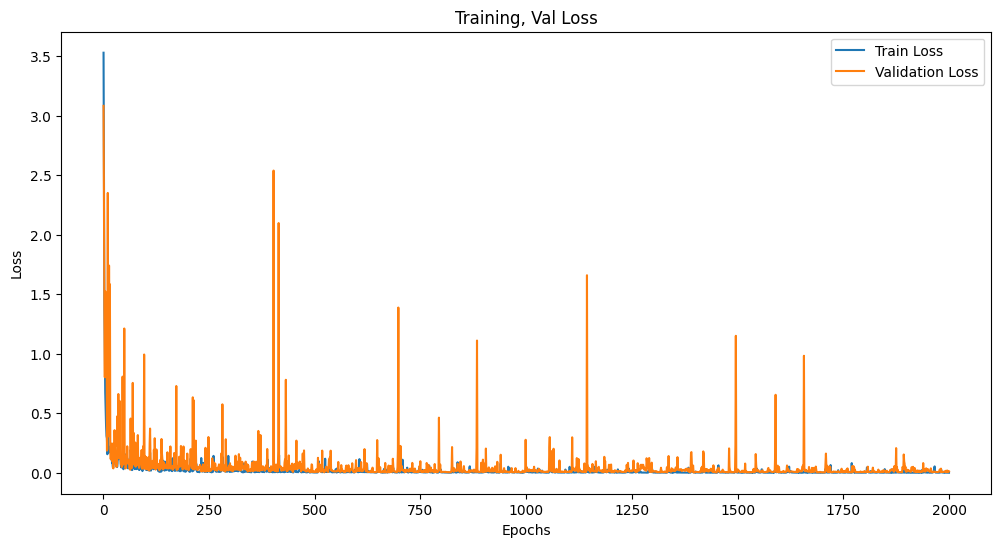

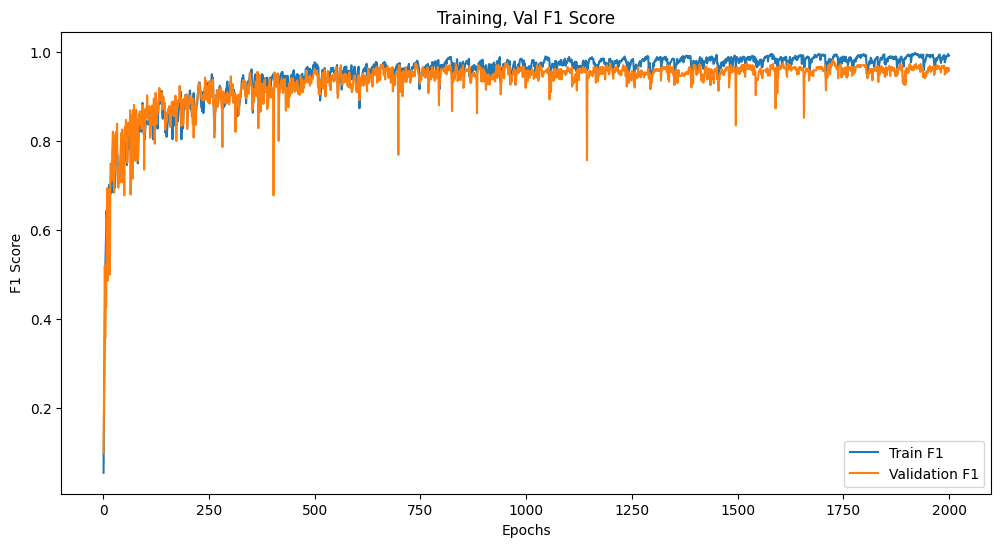

In [8]:
import matplotlib.pyplot as plt
#show history train and val loss
df = pd.DataFrame(history)
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
plt.plot(df['epoch'], df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Val Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train_f1'], label='Train F1')
plt.plot(df['epoch'], df['val_f1'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training, Val F1 Score')
plt.legend()
plt.show()

In [9]:
def load_model(model_path: str, num_joints: int, num_frames: int, num_classes: int, device: str = 'cpu'):
    """
    Load the trained JointSequenceResNet model from checkpoint.
    """
    model = JointSequenceResNet(num_joints=num_joints,
                                num_frames=num_frames,
                                num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [10]:
def inference(model: nn.Module,
              seq_tensor: torch.Tensor,
              device: str = 'cpu') -> list:
    """
    Run inference on one or more keypoint sequences.

    Args:
        model: Trained JointSequenceResNet in eval() mode.
        seq_tensor: Tensor of shape (N, T, V, 2) with float coords.
        device: 'cpu' or 'cuda'.

    Returns:
        List of N predicted class indices.
    """
    model.to(device)
    model.eval()
    with torch.no_grad():
        seq_tensor = seq_tensor.to(device)
        outputs = model(seq_tensor)           
        preds = outputs.argmax(dim=1).cpu().tolist()
    return preds

In [11]:
import mediapipe as mp
from config import Config
from detector import MediaPipeProcessor

pose = MediaPipeProcessor(Config())
pose = mp.solutions.holistic.Holistic(
        static_image_mode=False,
        model_complexity=1,
        smooth_landmarks=True,
        enable_segmentation=False,
        refine_face_landmarks=False,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    )
results = []

2025-07-01 16:36:49.872191: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 16:36:49.912310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751362609.940345    1946 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751362609.947552    1946 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-01 16:36:49.988889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
from collections import deque

def process_video(video_path, model, device, window_size=15):
    pose = MediaPipeProcessor(Config())
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video {video_path}")
    orig_fps = cap.get(cv2.CAP_PROP_FPS) or 6
    frame_interval = max(int(orig_fps // 6), 1)
    results = []
    frame_count = 0
    window = deque(maxlen=window_size)  # Use deque for efficient window management
    for _ in range(window_size):
        window.append(np.zeros((75, 2), dtype=np.float32))
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        # if frame_count % frame_interval != 0:
        #     continue
        # Process frame
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        _, result = pose.process_frame(rgb)
        frame_keypoints = pose.extract_keypoints(result)
        window.append(frame_keypoints)
        seq = np.stack(window, axis=0).astype(np.float32)  # (T, 75, 2)
        seq = torch.from_numpy(seq).unsqueeze(0).to(device)  # (1, T, 75, 2)
        seq = seq.permute(0, 2, 3, 1).contiguous()  # (1, 75, 2, T)
        # Inference
        with torch.no_grad():
            logits = model(seq)            # (1, num_classes)
            pred = logits.argmax(dim=1).item()    # scalar
        results.append(pred)

    cap.release()
    return results

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model("models/resnet_keypoints.pth",
                    num_joints=150,
                    num_frames=30,
                    num_classes=46,
                    device=device)


/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/na/anaconda3/envs/vslr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
path = "data/datatest"
video_files = [f for f in os.listdir(path) if f.endswith('.mp4')]
for video_file in video_files:
    video_path = os.path.join(path, video_file)
    print(f"Processing video: {video_path}")
    results = process_video(video_path, model, device, 30)
    print(f"Results for {video_file}: {results}")

Processing video: data/datatest/t.mp4
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75, 2, 30])
torch.Size([1, 75

KeyboardInterrupt: 